# BackPropagation with One Hidden Layer

This notebook implements a gradient descent algorithm using backprop for a shallow neural network with one hidden layer and a sigmoid activation. This neural network can be used for a shallow binary classification task. The purpose is to illustrate how backprop algorithm works on a neural network with a hidden layer.


![shallow neural net with one hiddne layer](
  https://drive.google.com/uc?export=view&id=1OqrYMeXo3Lx1XbKyOXmii6Pmycmuz2qE)

The computation here can be easily generalized to deep neural networks with any number of hidden layers.


## 1. Implementing the Learning Algorithm

### 1.1 Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




### 1.2 Parameter Initialization

First we write a method to initialize the parameters of the network ( i.e., the weight matrix and the bias for every layer).

It is common practice to initialize the weights to small random values and initialize biases to zeros.  The reason we need to randomly initialize the weights is to break the symmetry between the neurons in a layer. Recall that all neurons in the same layer compute the same function and get the same input matrix from their previous layer. The only thing that can make the neurons in a layer different from one another is their parameters. If all the neurons in the same layer have the same initial parameters they all endup having the same activation/output and the gradient descent algorithm by itself cannot break that symmetry because the parameters are all updated to the same values. This is not good because it reduces the effective capacity of our network. A layer with 100 neurons with the same parameters is effectively equivalent to a layer with a single neuron with that parameters. Random initialization of weights can break that symmetry.

We will talk more about different random initialization methods in a later chapter. For now we just set the weights to small unform random values between 0 and 0.01 and initialize all biases to zero. We store the parameters in a python dictionary so we can access them by their name. $W1$ and $W2$ are the weight matrices for  the neurons in layer 1 (hidden layer) and layer2 (output layer), respectively. $b1$ and $b2$ are the bias vectors for the hidden and output layers, respectively.

In [ ]:
"""
nx is the number of neurons in the input layer (i.e., the number of features in the dataset)
nh is the number of neurons in the hidden layer
ny is the number of neurons in the output layer (For this example we are using one nueron in the output layer so ny=1)
"""
def initialize_parameters(nx,nh1,ny):
    #set the random seed so the same random values are generated every time you run this function
    np.random.seed(1)


    #initialize weights to small random numbers and biases to zeros for each layer
    W1=np.random.uniform(size=(nh,nx), low=-0.01, high=0.01)
    b1=np.zeros((nh,1))
    W2=np.random.uniform(size=(ny,nh), low=-0.01, high=0.01)
    b2=np.zeros((ny,1))

    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

### 1.3 Forward Pass

Let's write utility methods to compute the activation function of the neurons. For this example, we set the activation for the nuerons in the hidden layer to relu and the neuron in the output layer has sigmoid activation.

In [ ]:
#relu activation
def relu(z):
    return np.maximum(0,z)

#sigmoid activation
def sigmoid(z):
    a= 1/(1+np.exp(-z))
    return a


Now let's write a method to do the forward pass. The method forward_pass takes the input dataset X and the network parameters (i.e., weights and biases)  and computes the network output $\hat{Y}$ by performing the operations in the computational graph.
Here is the computational graph for this shallow neural network with one hidden layer:

![title](https://drive.google.com/uc?export=view&id=1YgC5L93jnAqdYNJZGB_M2qxh6JYREmZH)


- $X$ is $nx\times n$ matrix where $nx$ is the number of features and $n$ is the number of examples in X.
- $W1$ is a $nh \times nx$ matrix where $nh$ is the number of neurons in the hidden layer
- $b1$ is a vector of length $nh$
- $Z1$ and $A1$ are both $nh \times n$ matrices
- $W2$ is a $1\times nh$ matrix
- $Z2$ and $Yhat$ are both $1\times n$ matrices

We want to return the intermediate values A1 and Z2 in addition to the output Yhat to use them in the backward pass. So we create a dictionary, cache, to store these values and returned it.
    


In [ ]:
"""
In forward pass we do the computations in the computational graph. We cache the intermediate nodes we will later need in the backward pass
"""
def forward_pass(parameters,X):
    Z1= np.dot(parameters["W1"],X)+parameters["b1"] # b1 is broadcasted n times before it is added to np.dpt(W1,X1)
    A1=relu(Z1)
    Z2=np.dot(parameters["W2"],A1)+parameters["b2"] #b2 is broadcasted n times before it is added to np.dpt(W2,A1)
    Yhat=sigmoid(Z2)

    cache = {"A1": A1,
             "Z1":Z1,
             "Z2": Z2}
    return Yhat,cache


Let's also write a utility method to compute the loss

In [ ]:
"""
n is the number of examples, y is a vector of actual/observed outputs and yhat is a vector of predicted outputs
"""
def compute_loss(Y,Yhat):

    n=Y.shape[1]
    loss=(-1 / n) * np.sum(Y * np.log(Yhat) + (1 - Y) * (np.log(1 - Yhat)))
    return loss


### 1.3 Backward Pass

Before doing the backward pass, lets write utility functions to compute the gradients of binary cross entropy loss, sigmoid, and relu.

Recall from the lectures that
BinaryLoss is
$L=-1/n \sum_{i}{y_ilog(\hat{y_i})+(1-y_i)log(1-\hat{y_i})}$
So for one example $i$, the loss would be as follows:
$\frac{dL}{d\hat{y_i}}=\frac{-y_i}{\hat{y_i}}+\frac{(y_i -1)(-1)}{1-\hat{y_i}}=\frac{\hat{y_i}-y_i}{\hat{y_i}(1-\hat{y_i})}$

Similary, recall from lecture 2.3 that $\hat{y_i}=sigmoid(z)=\frac{1}{1+exp(-z)}$ so $\frac{d}{dz}sigmoid(z)=\frac{exp(-z)}{(1+exp(-z))^2}=\hat{y_i}(1-\hat{y_i})$

The derivative of $relu(z)=max(z,0)$ with respect to z  is equal to 1 when z>0 otherwise it is zero.
Relu is not differentiable at =0 but we can conventionally set the derivative to zero at z=0



In [ ]:
'''
Y is the observed output and Yhat is the predicted output (i.e., output of the network)
The derivative of binary cross entropy loss with respect to Yhat is (Yhat-Y)/(Yhat*(1-Yhat))
where / and * are both elementwise operation
'''
def dBinaryLoss(Y,Yhat):
    return (Yhat-Y)/(Yhat*(1-Yhat))


'''
The derivative of sigmoid(A) with respect to A is A*(1-A)
where * is elementwise multiplication
'''
def dsigmoid(Z):
    A=sigmoid(Z)
    return (A*(1-A))


def drelu(Z):
    """
np.where(condition, x, y) for each element of the array returns x if condition is true otherwise returns y.
In this case for each element Z drelu=1 if the element is greater than 0 otherwise drelu=0
"""
    drelu=np.where(Z>0, 1.0, 0.0)
    return drelu


Now we are ready to write the backward pass function. The local gradients needed for the backward pass are shown in the computational graph.
![title](https://drive.google.com/uc?export=view&id=1t_4IPKdm2tsPUuB6Il3TUXI-doe1DBZX)
To compute the gradient of loss with respect to each node we move backward from the loss to that node multiplying the local grdients along the path.




$\frac{\partial{L}}{\partial{Z^{[2]}}}=dBinaryLoss(Y,\hat{Y})*dsigmoid(Z^{[2]})$

$\frac{\partial{L}}{\partial{W^{[2]}}}=\frac{1}{n}\frac{\partial{L}}{\partial{Z^{[2]}}}{A^{[1]}}^T $

$\frac{\partial{L}}{\partial{b^{[2]}}}=\frac{1}{n}\sum_{j=1}^{n}{\frac{\partial{L}}{\partial{Z_{j}^{[2]}}}} $

$\frac{\partial{L}}{\partial{A^{[1]}}}={W^{[2]}}^T\frac{\partial{L}}{\partial{Z^{[2]}}} $

$\frac{\partial{L}}{\partial{Z^{[1]}}}=\frac{\partial{L}}{\partial{A^{[1]}}}*drelu(Z^{[1]})$

$\frac{\partial{L}}{\partial{W^{[1]}}}=\frac{1}{n}\frac{\partial{L}}{\partial{Z^{[1]}}}X^T $

$\frac{\partial{L}}{\partial{b^{[1]}}}=\frac{1}{n}\sum_{j=1}^{n}{\frac{\partial{L}}{\partial{Z_{j}^{[1]}}}} $

Where * is element-wise multiplication for two matrices of the same dinesion.
The above computations are mostly straightforward ( follow directly from moving backwards from the loss (last node) in the computational graph multiplying the gradients).

The one operation that might need clarification, however, is the gradient of matmul (matrix multiplication) operation. If we have a matrix multiplication operation $Z=WA$ which recieves an upstream gradient$\frac{\partial{L}}{\partial{Z}}$ as shown in the following graph
                            
![gradient of matmul](https://drive.google.com/uc?export=view&id=1SHA16ff2v0deVuqf1buXDiRKJ9gDquGR)

Then the gradients of matmul operation with respect to $W$ and $A$ are calculated as follws:

$\frac{\partial{L}}{W}=\frac{\partial{L}}{\partial{Z}}A^T$ where $A^T$ is the transpose of matrix A.

$\frac{\partial{L}}{A}=W^T\frac{\partial{L}}{\partial{Z}}$ where $W^T$ is the transpose of matrix W.

The proof of this requires knowledge of matrix claclus and multi-variable chain rule which is outside of the scope of this lecture but if you are interested to see how this is derived you can refer to [this short lecture from stanford](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

Also sincec the loss function is averaged over all training examples, the gradient of weights and biases are also averaged over trainng examples before they are updated using gradient descent. You might be wondering why we are summing the bias terms when computing the gradients but not the weights. The reason is the matrix multiplication $\frac{\partial{L}}{Z}A^T$ takes care of summing over the training examples and we don't have to explicity do it.

In [ ]:
def backward_pass(parameters, cache, X, Y, Yhat):
    n=X.shape[1]
    dZ2=dBinaryLoss(𝑌,Yhat )*dsigmoid(cache["Z2"])
    dW2=(1/n)*np.dot(dZ2,cache["A1"].T)
    db2=(1/n)*np.sum(dZ2, axis=1, keepdims=True)
    dA1=np.dot(parameters["W2"].T,dZ2)
    dZ1=dA1*drelu(cache["Z1"])
    dW1=(1/n)*np.dot(dZ1,X.T)
    db1=(1/n)*np.sum(dZ1, axis=1, keepdims=True)
    gradients={"dW1": dW1,
             "db1": db1,
             "dW2":dW2,
              "db2":db2
              }
    return gradients




### 1.4 Using Gradient Descent To update the parameters

Now we hare ready to implement the gradient descent learning algorithm to update the network parameters.

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"]=parameters["W1"]-learning_rate*gradients["dW1"]
    parameters["W2"]=parameters["W2"]-learning_rate*gradients["dW2"]
    parameters["b1"]=parameters["b1"]-learning_rate*gradients["db1"]
    parameters["b2"]=parameters["b2"]-learning_rate*gradients["db2"]
    return parameters

### 1.5 Putting it all together, Creating the NN Model
Now we can put everything together to train our NN model. By training we mean run a given number of gradient descent iteratiosn to update and return the network parameters.

In [ ]:
"""
Arguments: train_X: is the training dataset (features)
           train_Y: is the vector of labels for training_X
           val_X: is the vector of validation dataset (features)
           val_y: is the vector of labels for val_X
           nh: is the number of neurons in the hidden layer
           num_iterations: The number of iterations of gradient descent
"""
def create_nn_model(train_X,train_Y,nh, val_X, val_Y, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=1

    # initializing the parameteres
    parameters=initialize_parameters(nx,nh,ny)


    #initialize lists to store the training and valideation losses for each iteration.
    val_loss=[]
    train_loss=[]

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):
        #run the forward pass on train_X
        Yhat_train, train_cache= forward_pass(parameters,train_X)

        #run the forward pass on val_X
        Yhat_val,val_cache= forward_pass(parameters,val_X)

        #compute the loss on the train and val datasets
        train_loss.append(compute_loss(train_Y,Yhat_train))
        val_loss.append(compute_loss(val_Y,Yhat_val))


        """
        run the backward pass. Note that the backward pass is only run on the training data not the validation data
        Because the learning must be only done on the training data and hence, validation data is not used to update
        the model parameters.
        """
        gradients=backward_pass(parameters, train_cache, train_X, train_Y,Yhat_train)


        # update the parameters
        parameters=update_parameters(parameters, gradients, learning_rate)

        #print the trianing loss and validation loss for each iteration.
        print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss[i],val_loss[i]))

    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_loss,
             "train_loss": train_loss}


        #return the parameters and the history
    return parameters, history





### 1.5 predicting and evaluating the NN model
After training our nn mode, we can use it to predict the label for a given example. The output of the neuron in the output layer is the predicted probability that the example belongs to class 1. If this probability is greater or equal than a given threshold, we classify the example data as 1 otherwise as zero. If no threshold is given, we use 0.5 as the cutoff.

In [ ]:
def predict(parameters,X, prob_threshold=0.5):
    Yhat,cache=forward_pass(parameters, X)
    # predict class 1 if the output is greater than prob_threshold; otherwise, predict zero
    predicted_label=np.where(Yhat>prob_threshold, 1, 0)
    return predicted_label

We can also write a simple method to comput ethe accurracy of a model given the predicted and actual/observed labels.  The accurracy is defined as the proportion of the correctly labeled examples.

In [ ]:
def accuracy(observedY,predictedY):
    #return the ratio of the examples for which predictedY=observedY over the total number of examples
    return float(np.sum(predictedY==observedY))/observedY.size

## 2. Applying the NN model to classify Cat and Dog Images
Let's apply this shallow NN model with one hidden layer to dogs vs cats dataset from Kaggle website:https://www.kaggle.com/c/dogs-vs-cats. This dataset was made available by Kaggle as part of a computer-vision competition in late 2013. This dataset contains 25,000 medium resolution JPEG images of dogs and cats (12,500 from each class). Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants
who used Convolutional neural network, a type of deep neural network used in computer vision. The best entries achieved up to 95% accuracy.
We will discuss convolutional neural networks in a later chapter and will be able to get fairly close to and surpass this accuracy.

But for now let's train our shallow neural network on this dataset. Obviously this shallow neural network is not going to perform well on this dataset because it does not have enough capcity to represent the data. But it will help use illustrate how we can apply the nn model we just developed to some real-world data.

The images are of varying sizes. I took a uniform sample of 2500 images from this dataset. I preprocessed the images and resized them to 64(height)$\times$64(width)$\times$3 (RGB channels) pixels. Each pixel value is a number between 0-1 representing the brightness of that pixel. In order to prepare the data for our neural network model, I reshaped  it into a 2d array with 64$\times$64$\times$3 rows and 2500 columns where each row represents a pixel and each column represents a single image. I added the labels (0 for cat and 1 for dog) as an additional row. So the final array had 64$\times$64$\times$3+1 rows and 2500 columns.  I splitted this array randomly into two arrays for training and validation with 2000 and 500 images, respectively and saved them into train.csv and validation.csv files.

I intentially left out the code for preprocessing from this notebook. We will later learn how to use Keras ( a popular deep learning framework) to automatically do these types of image preprocessing.

I have uploaded the processed files on box and we can directly download it here using wget command.:


In [ ]:
# downloading the files from theb box
!wget --no-check-certificate  --content-disposition "https://uofi.box.com/shared/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip"


--2022-02-14 03:29:02--  https://uofi.box.com/shared/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip
Resolving uofi.box.com (uofi.box.com)... 107.152.25.197
Connecting to uofi.box.com (uofi.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip [following]
--2022-02-14 03:29:02--  https://uofi.box.com/public/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip [following]
--2022-02-14 03:29:02--  https://uofi.app.box.com/public/static/ezda2j2u9n7arw18vefrfqp7w2gs1kcx.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 107.152.25.201
Connecting to uofi.app.box.com (uofi.app.box.com)|107.152.25.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [ ]:
#extracting the zip file
import os
import zipfile
zip_ref = zipfile.ZipFile('cat-vs-dog-processed.zip', 'r')
zip_ref.extractall()

# reading the input datasets train.csv and validation.csv and store them into numpy arrays
train=pd.read_csv("cat-vs-dog-processed/train.csv", header=None).to_numpy()
val = pd.read_csv('cat-vs-dog-processed/validation.csv', header=None).to_numpy()
print(train.shape)
print(val.shape)

(12289, 2000)
(12289, 500)


I separated the features from labels for training and validation data and stored them in separate numpy arrays.

In [ ]:
#everything minus the last row is X
train_X=train[:-1,]
#the last row (at index -1) is Y
train_Y=train[-1,:]

# the labels train_Y and val_Y have to be reshaped to a 2D array for the matrix operations to work in the forward and backward passes
train_Y=np.reshape(train_Y, (1,train_Y.size))

val_X=val[:-1,]
val_Y=val[-1,]
val_Y=np.reshape(val_Y, (1,val_Y.size))

print(train_X.shape)
print(val_X.shape)
print(train_Y.shape)
print(val_Y.shape)

print(train_Y)


(12288, 2000)
(12288, 500)
(1, 2000)
(1, 500)
[[0. 1. 0. ... 1. 0. 1.]]


Let's check out the first ten imagas in training and validation set together with their labels

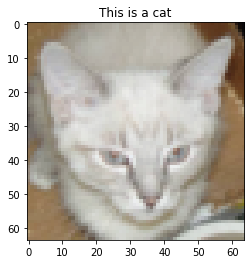

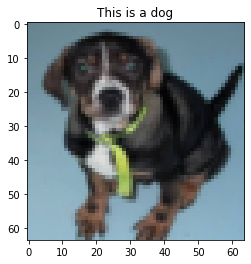

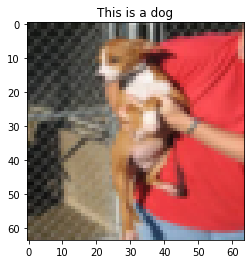

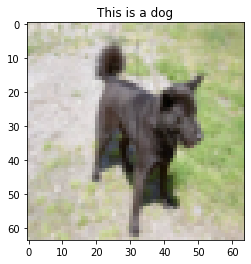

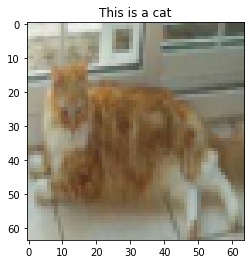

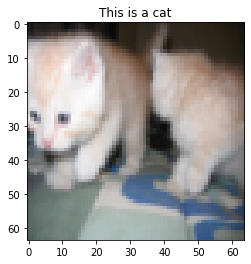

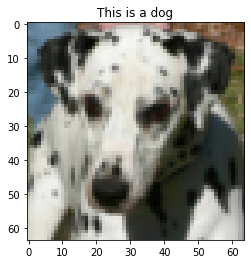

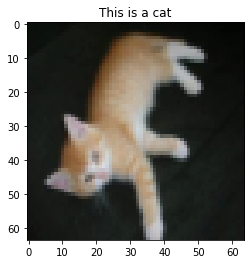

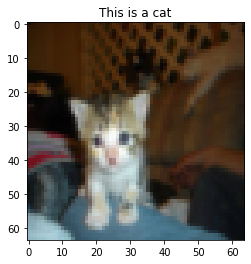

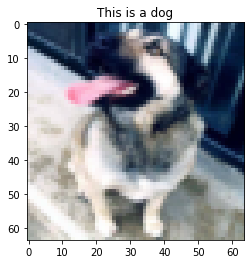

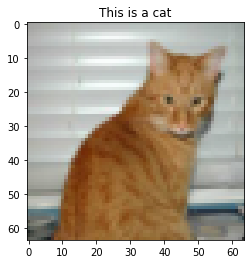

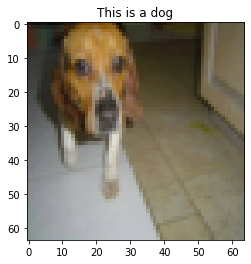

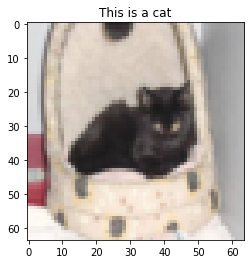

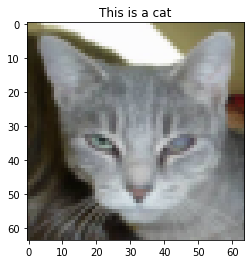

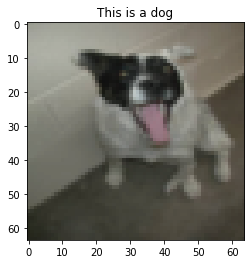

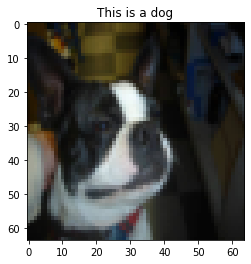

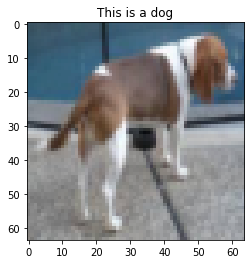

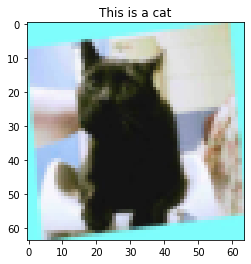

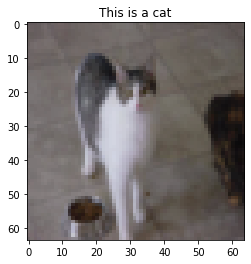

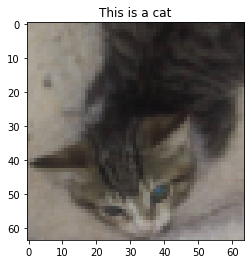

In [ ]:

for i in range(10):
    image=train_X[:,i].reshape(64,64,3)
    plt.imshow(image)
    plt.title("This is a {}".format("dog" if train_Y[:,i]==1 else "cat"))
    plt.show()
    image=val_X[:,i].reshape(64,64,3)
    plt.title("This is a {}".format("dog" if val_Y[:,i]==1 else "cat"))

    plt.imshow(image)
    plt.show()

Ok. We are now ready to train our model on on this data. The train and validation loss is printed after each iteration of gradient descent.
There are a few parameters that we need to give to our model before it can start the learning from the data, such as the number of neurons in the hidden layer, the learning rate, and the number of iterations of gradient descent. These are the *hyperparameters* of our model. There is no golden rule on what values these hyperparameters should take. In the next module we will discuss sysmtematic ways to search for good hyper-parameter values for now let's just set the number of neurons in the hidden layer to 50, the learning rate to 0.01 and the number of iterations to 1000. You can play around with different hyper-parameter values and see their impact on the training and validation losses.

Ok. We are now ready to train our model on on this data. The train and validation loss is printed after each iteration of gradient descent.
There are a few parameters that we need to give to our model before it can start the learning from the data, such as the number of neurons in the hidden layer, the learning rate, and the number of iterations of gradient descent. These are the *hyperparameters* of our model. There is no golden rule on what values these hyperparameters should take. In the next module we will discuss sysmtematic ways to search for good hyper-parameter values for now let's just set the number of neurons in the hidden layer to 50, the learning rate to 0.01 and the number of iterations to 2000. You can play around with different hyper-parameter values and see their impact on the training and validation losses.

Also keep in mind that the initial choice of random values for the parameters can greatly affect the performance of gradient descent. We will talk more about this topic in a later module when we talk about optimization algorithms for deep learning. Bur for now, try changing the range of initial random values for weights to see how it affect the performance of your model.

In [ ]:
iterations=2000
parameters, history=create_nn_model(train_X,train_Y,50, val_X, val_Y, iterations, 0.01)

iteration 0 :train_loss:0.6930148734947061 val_loss0.6931388992028822
iteration 1 :train_loss:0.6930053195901351 val_loss0.6931316771098335
iteration 2 :train_loss:0.6929958359765449 val_loss0.6931244525152397
iteration 3 :train_loss:0.6929865320400699 val_loss0.6931171933953386
iteration 4 :train_loss:0.6929772494891627 val_loss0.6931099295278521
iteration 5 :train_loss:0.6929680594433567 val_loss0.6931026640850187
iteration 6 :train_loss:0.6929589692699909 val_loss0.6930953994118586
iteration 7 :train_loss:0.6929499198479123 val_loss0.6930881418427552
iteration 8 :train_loss:0.6929408895479683 val_loss0.6930808364555637
iteration 9 :train_loss:0.692931913443367 val_loss0.6930735195237014
iteration 10 :train_loss:0.6929229789506692 val_loss0.693066171638089
iteration 11 :train_loss:0.6929139773509287 val_loss0.6930587804696454
iteration 12 :train_loss:0.6929049341943496 val_loss0.693051507483653
iteration 13 :train_loss:0.6928958981270323 val_loss0.6930443949772194
iteration 14 :train

Now we can go ahead and plot the validation and training loss per iteration of gradient descent. This plot is commonly referred
to as the *learning curve* and is very helpful in diagnosing our neural network model. We can see from this learning curve that the training loss (blue curve)  continues to decrease all the way to around iteration 1250 after which it slightly goes up before it goes down again. This suggests that learning rate ( which we set to 0.01 in this model) might be too high after this iteration causing the gradient descent algorithm to take a larger than optimal step.  he fact that the training loss starts to fluctuate after this iteration also confirms that the learning rate is too high at that point. In a later module ( optimization module) we will talk about different techniques to adjust the learning rate.

The validation loss also decreases all the way to around iteration 1250 after which it goes up. The gap between the validation loss and training loss increases after around 400 iteration showing that the model is overfitting.  This means, as we continue the training,  the model is starting to learn features that are specific to the training data that do not generalize well beyond to the validation data( e.g., it might recognize a door or a window or something else in the background as being related to having a cat or dog in the image)

In next two modules, we will focus on techniques to improve the training error ( i.e., the optimization algorithms) and the gap between the training and validation error (i.e., generalization)

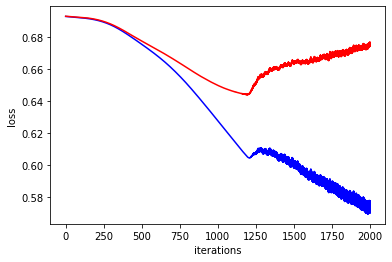

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

Now let's compute the accurracy of our model on the training and validation data. unsuprisingly, the accurracy on the training data is much better than the validation data because of the overfitting. The accurracy of the validation data ( which is what matters) is very low ( just slightly better than random) which tells us that this model is not a good model for this dataset.


We can try to use more data to train our model or use regularization ( as we will see in the next module) to battle overfitting. But even then, we might only be able to only slightlhy increase the validation accurracy. The reason is that a stack of  fully connected layers of neurons is not a good network architecture for a comptuer vision task and does not take advantage of the spatial information in the image. In a later module, we will discuss convolutional neural networks (CNN) which are a type of feedforward neural network optimised for computer vision tasks and will be able to get a much better validation accurracy on this dataset using CNN.



In [ ]:

predicted_train=predict(parameters, train_X)
predicted_val=predict(parameters, val_X)

print("accurracy of the model on the training data is:", accuracy(train_Y,predicted_train))
print("accurracy of the model on the validation data is:", accuracy(val_Y,predicted_val))

accurracy of the model on the training data is: 0.71
accurracy of the model on the validation data is: 0.586


# References
This notebook is heavily inspired by the following work:
 1.   Andrew Ng, Neural Network and Deep Learning course, https://www.coursera.org/learn/neural-networks-deep-learning

